In [26]:
%matplotlib inline
# Import the modules
import requests
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import requests 
from config import yelpkey, gkey

In [27]:
# Define API Key, Endpoint, and Header
API_KEY = yelpkey
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization': 'bearer %s' % API_KEY}

In [28]:
# import NY zip codes list from CSV & convert into dataframe
# note, to test, I'm using an abbreciated version of our zip code list 

zipcodes_data = "clean_nyc_zips.csv"
zipcodes_df = pd.read_csv(zipcodes_data)
zipcodes_df.columns = ['Zip Code']
zipcodes_df.head()

,Zip Code
0,10001
1,10002
2,10003
3,10004
4,10005


In [29]:
# Add column to hold number of restaurants
zipcodes_df["# Pizza/Chinese Restaurants"] = ""
zipcodes_df.head()

,Zip Code,# Pizza/Chinese Restaurants
0,10001,
1,10002,
2,10003,
3,10004,
4,10005,


In [46]:
# create a loop that looks up the zip in each row and adds total # Chinese rest to the column
for index, row in zipcodes_df.iterrows():    
    zip = row['Zip Code']
    PARAMETERS = {'categories': 'restaurant,chinese,pizza,All',
                  'location': zip,
                  'limit': 50,
                  'offset': 0,
                  'sort_by': 'distance'}
    try:
        print(f'Finding "{PARAMETERS["categories"]}" info for zip code: {zip}')
        business_data = requests.get(url=ENDPOINT, params=PARAMETERS, headers=HEADERS).json()
        print(f'Total Results: {business_data["total"]}')
        
        # loop through the search results, counting up the ones that are actually in the zip code
        count_in_zip = 0
        count_deliver_in_zip = 0
        if 'businesses' in business_data:
            for restaurant in business_data['businesses']:
                if restaurant['location']['zip_code'] == str(PARAMETERS['location']):
                    count_in_zip += 1
                    if 'delivery' in restaurant['transactions']:
                        count_deliver_in_zip += 1

            # if the requested search result total is larger than 50 (max request size), we need to make
            # multiple requests to get all the data. We do this using the 'offset' parameter. However, Yelp 
            # only allows us to pull up to 1000 search results, so we also need to make sure we don't loop
            # past 1000 results
            if int(business_data['total']) > 50:
                yelp_result_count = 1000 if int(business_data['total']) > 1000 else int(business_data['total'])
                for i in range(PARAMETERS['limit'], yelp_result_count, 50):
                    PARAMETERS['offset'] = i
                    business_data = requests.get(url=ENDPOINT, params=PARAMETERS, headers=HEADERS).json()
                    if 'businesses' in business_data:
                        for restaurant in business_data['businesses']:
                            if restaurant['location']['zip_code'] == str(PARAMETERS['location']):
                                count_in_zip += 1
                                if 'delivery' in restaurant['transactions']:
                                    count_deliver_in_zip +=1
        else:
              print('No data, skipping')
                       
        # add to df and print how many found direclty in zip code
        zipcodes_df.loc[index, "# Pizza/Chinese Restaurants"] = count_in_zip
        zipcodes_df.loc[index, "# That Deliver"] = count_deliver_in_zip
        if count_in_zip != 0:
            zipcodes_df.loc[index, "% That Deliver"] = count_deliver_in_zip / count_in_zip
        else:
            zipcodes_df.loc[index, "% That Deliver"] = 0
    except json.decoder.JSONDecodeError:
        print("Missing field/result... skipping.")
    print("-------------------------------------------")

Finding "restaurant,chinese,pizza,All" info for zip code: 10001
Total Results: 192
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10002
Total Results: 276
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10003
Total Results: 220
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10004
Total Results: 837
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10005
Total Results: 57
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10006
Total Results: 46
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10007
Total Results: 39
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10009
Total Results: 169
-------------------------------

Total Results: 119
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10462
Total Results: 112
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10463
Total Results: 317
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10464
Total Results: 470
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10465
Total Results: 1000
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10466
Total Results: 44
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10467
Total Results: 334
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 10468
Total Results: 153
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for 

Total Results: 39
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11361
Total Results: 61
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11362
Total Results: 43
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11363
Total Results: 20
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11364
Total Results: 59
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11365
Total Results: 77
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11366
Total Results: 560
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip code: 11367
Total Results: 77
-------------------------------------------
Finding "restaurant,chinese,pizza,All" info for zip cod

In [47]:
# print the data frame, which should now include the Chinese restaurant count by zip
zipcodes_df.head()

,Zip Code,# Pizza/Chinese Restaurants,# That Deliver,% That Deliver,% No Cars
0,10001,50,35.0,0.700000,82.6
1,10002,160,54.0,0.337500,81.6
2,10003,89,62.0,0.696629,78.3
3,10004,20,12.0,0.600000,81.1
4,10005,6,4.0,0.666667,83.5


In [48]:
# call to the census api and get info about # without cars
base_url = "https://api.census.gov/data/2017/acs/acs5/profile"
hh_no_vehicles = "DP04_0058PE"
for index, row in zipcodes_df.iterrows():    
    zip = str(row['Zip Code']).replace('.0','')
    query_url = f"{base_url}?get={hh_no_vehicles},NAME&for=zip%20code%20tabulation%20area:{zip}&key={gkey}"
    try:
        print(f"Finding demo data for zip code: {zip}")
        response = requests.get(query_url).json()
        zipcodes_df.loc[index, "% No Cars"] = response[1][0]
    except json.decoder.JSONDecodeError:
        print("Missing field/result... skipping.") 
    print("-------------------------------------------")

Finding demo data for zip code: 10001
-------------------------------------------
Finding demo data for zip code: 10002
-------------------------------------------
Finding demo data for zip code: 10003
-------------------------------------------
Finding demo data for zip code: 10004
-------------------------------------------
Finding demo data for zip code: 10005
-------------------------------------------
Finding demo data for zip code: 10006
-------------------------------------------
Finding demo data for zip code: 10007
-------------------------------------------
Finding demo data for zip code: 10009
-------------------------------------------
Finding demo data for zip code: 10010
-------------------------------------------
Finding demo data for zip code: 10011
-------------------------------------------
Finding demo data for zip code: 10012
-------------------------------------------
Finding demo data for zip code: 10013
-------------------------------------------
Finding demo dat

-------------------------------------------
Finding demo data for zip code: 11214
-------------------------------------------
Finding demo data for zip code: 11215
-------------------------------------------
Finding demo data for zip code: 11216
-------------------------------------------
Finding demo data for zip code: 11217
-------------------------------------------
Finding demo data for zip code: 11218
-------------------------------------------
Finding demo data for zip code: 11219
-------------------------------------------
Finding demo data for zip code: 11220
-------------------------------------------
Finding demo data for zip code: 11221
Missing field/result... skipping.
-------------------------------------------
Finding demo data for zip code: 11222
-------------------------------------------
Finding demo data for zip code: 11223
-------------------------------------------
Finding demo data for zip code: 11224
-------------------------------------------
Finding demo data fo

In [49]:
zipcodes_df

,Zip Code,# Pizza/Chinese Restaurants,# That Deliver,% That Deliver,% No Cars
0,10001,50,35.0,0.700000,82.6
1,10002,160,54.0,0.337500,81.6
2,10003,89,62.0,0.696629,78.3
3,10004,20,12.0,0.600000,81.1
4,10005,6,4.0,0.666667,83.5
5,10006,12,10.0,0.833333,84.1
6,10007,17,14.0,0.823529,71.0
7,10009,38,29.0,0.763158,80.4
8,10010,30,24.0,0.800000,75.7
9,10011,48,39.0,0.812500,80.2


In [50]:
zipcodes_df


,Zip Code,# Pizza/Chinese Restaurants,# That Deliver,% That Deliver,% No Cars
0,10001,50,35.0,0.700000,82.6
1,10002,160,54.0,0.337500,81.6
2,10003,89,62.0,0.696629,78.3
3,10004,20,12.0,0.600000,81.1
4,10005,6,4.0,0.666667,83.5
5,10006,12,10.0,0.833333,84.1
6,10007,17,14.0,0.823529,71.0
7,10009,38,29.0,0.763158,80.4
8,10010,30,24.0,0.800000,75.7
9,10011,48,39.0,0.812500,80.2


In [57]:
zipcodes_df.to_csv('delivery_dataframe_run.csv', index=False,header=True)

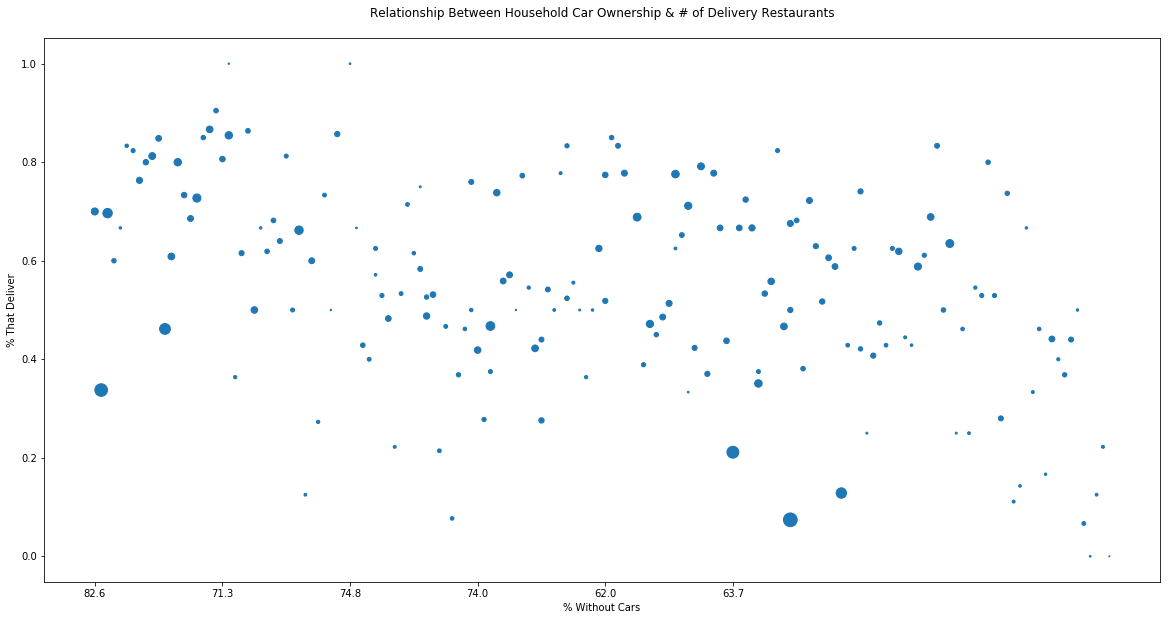

In [56]:
plt.scatter(zipcodes_df['% No Cars'], zipcodes_df['% That Deliver'], s=zipcodes_df['# Pizza/Chinese Restaurants'])
plt.rcParams['figure.figsize'] = (20,10)
plt.title(f'Relationship Between Household Car Ownership & # of Delivery Restaurants\n')
plt.ylabel('% That Deliver')
plt.xlabel('% Without Cars')
plt.xticks([0,20,40,60,80,100])
plt.show()